In [36]:
import datetime
import sys
sys.path.append("..")
import random
from numpy.random import default_rng
from annoy import AnnoyIndex
import torch.autograd as autograd
from typing import List
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from sklearn.metrics import (adjusted_rand_score, calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing


import utils
from sklearn import metrics
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional
import torch.nn.functional as F
from random import sample
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import scanpy as sc
import time
import os

from sklearn.metrics import fbeta_score

from matplotlib_venn import venn3, venn2

# from torch.cuda.amp import GradScaler, autocast

torch.cuda.set_device(1)

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
path= "../"
# check available files
# !ls ../real_data

# torch.autograd.set_detect_anomaly(True)
import matplotlib
from matplotlib.pyplot import rc_context
matplotlib.rcParams['patch.edgecolor'] = 'black'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import seaborn as sns

In [38]:
from matplotlib_venn import venn3

In [39]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.7.1


In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300)

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


In [96]:
model = "genex"

adata_int = sc.read_h5ad('%s_pbmc_2.h5ad' % (model))

# adata_int.var.index = adata_int.var["gene_name"]

adata_int

AnnData object with n_obs × n_vars = 15476 × 10000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_num'
    var: 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'CellType_colors', 'batch_colors', 'hvg', 'log1p', 'louvain', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    layers: 'X_raw', 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'

In [97]:
# uncomment this for our model.
if "X_raw" not in adata_int.layers:
    adata = sc.read_h5ad('genex_pbmc.h5ad')
    
    # subset to only two cell types that has subtle different which are acinar and ductal cell type
#     adata = adata[adata.obs["celltype"].isin(subset_celltype)].copy()
    
    adata_int.layers["X_raw"] = adata.layers["X_raw"].copy()
    adata_int.uns = adata.uns

In [98]:
# adding the scale value for heatmap and dotplot visualisation

adata_int.layers["X_raw_scaled"] = sc.pp.scale(adata_int.layers["X_raw"].copy(), copy = True)
adata_int.layers["X_corrected_scaled"] = sc.pp.scale(adata_int.obsm["X_latent"].copy(), copy = True)

In [99]:
# # subset to only two cell types that has subtle different which are acinar and ductal cell type
# subset_celltype = ["acinar", "ductal"]

# adata_int = adata_int[adata_int.obs["celltype"].isin(subset_celltype)].copy()

In [100]:
# # remove minority class as we have seen that 5 cell type are very rare
# counts = adata_int.obs["CellType"].value_counts()
# minority_classes = counts.index[-3:].tolist()        # get the minority classes
# adata_int = adata_int[                               # actually subset
#     ~adata_int.obs["CellType"].isin(minority_classes)]
# adata_int.obs["CellType"].cat.reorder_categories(       # reorder according to abundance
#     counts.index[:-3].tolist(), inplace=True)

In [101]:
adata_int.layers["X_corrected"] = adata_int.obsm["X_latent"].copy()

In [102]:
# split per batch into new objects.
batches = list(set(adata_int.obs['batch']))
alldata = {}
for batch in batches:
    alldata[batch] = adata_int[adata_int.obs['batch'] == batch,]

alldata    

{'0': View of AnnData object with n_obs × n_vars = 8098 × 10000
     obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_num'
     var: 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
     uns: 'CellType_colors', 'batch_colors', 'hvg', 'log1p', 'louvain', 'neighbors', 'umap'
     obsm: 'X_latent', 'X_pca', 'X_umap'
     layers: 'X_raw', 'counts', 'log_norm', 'X_raw_scaled', 'X_corrected_scaled', 'X_corrected'
     obsp: 'connectivities', 'distances',
 '1': View of AnnData object with n_obs × n_vars = 7378 × 10000
     obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_num'
     var: 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
     uns: 'CellType_colors', 'batch_colors', 'hvg', 'log1p', 'louvain', 'neighbors', 'umap'
     obsm: 

In [103]:
# # get only the common cell type across all batches
# common_celltype_list = []

# for each in alldata:
#     celltype_list = list(set(alldata[each].obs["CellType"]))
    
#     common_celltype_list.append(celltype_list)
    
# common_celltype = list(set.intersection(*map(set,common_celltype_list)))

In [104]:
# common_celltype

In [105]:
# adata_int = adata_int[adata_int.obs["CellType"].isin(common_celltype)].copy()

In [106]:
adata_int

AnnData object with n_obs × n_vars = 15476 × 10000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_num'
    var: 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'CellType_colors', 'batch_colors', 'hvg', 'log1p', 'louvain', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    layers: 'X_raw', 'counts', 'log_norm', 'X_raw_scaled', 'X_corrected_scaled', 'X_corrected'
    obsp: 'connectivities', 'distances'

In [107]:
# adata_int.layers["X_raw"].toarray()

In [108]:
# adata_int.layers["X_raw"]

In [109]:
adata_int.layers["X_corrected"]

array([[0.        , 0.        , 0.        , ..., 0.08804815, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.06247318, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.09831575, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [110]:
# adata_int.uns['log1p'] = None
adata_int.uns['log1p']['base'] = None

In [111]:
plt.rcdefaults()

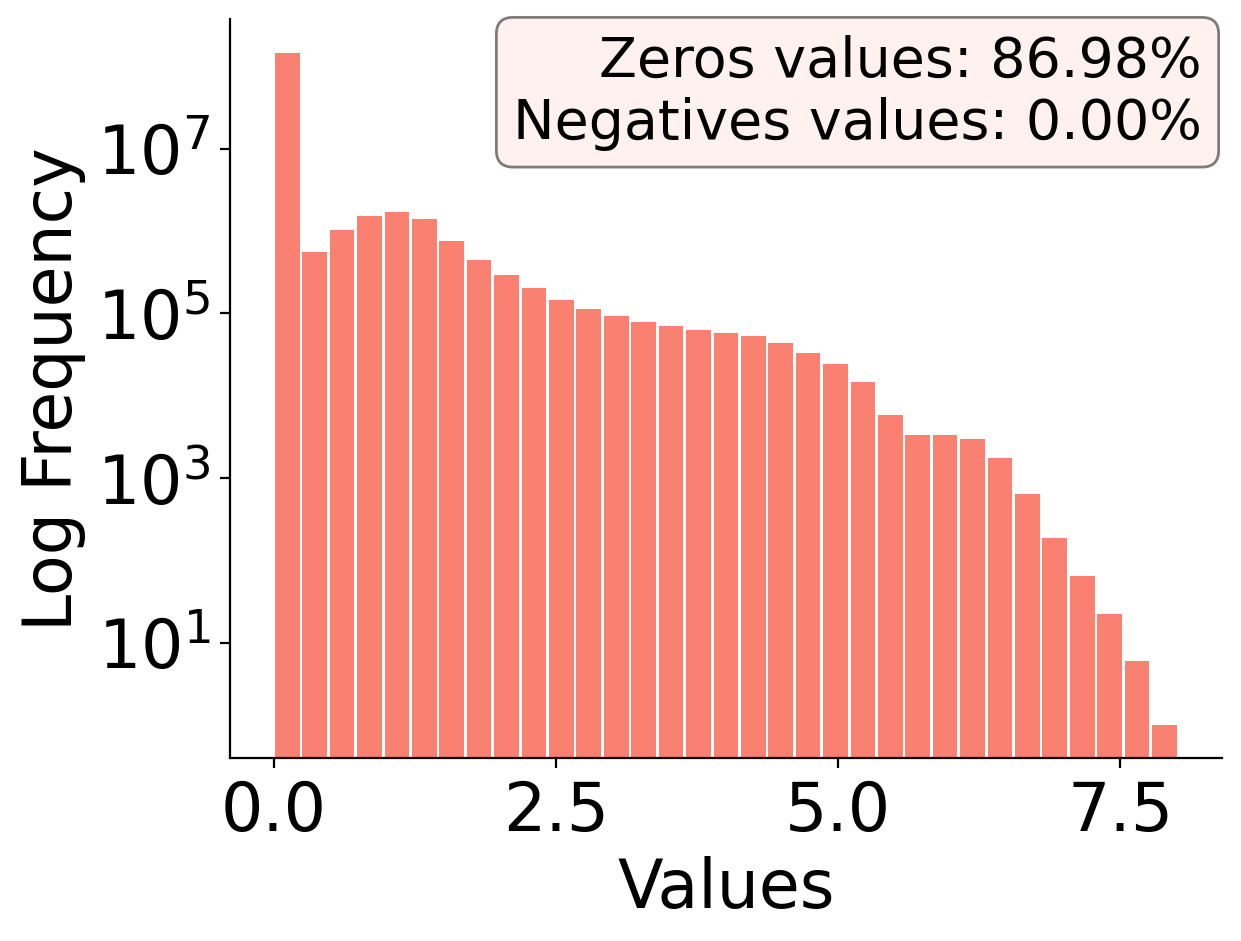

In [112]:
raw_array = adata_int.layers["X_corrected"]

# Flatten the 2D array to 1D
flattened_array = raw_array.flatten()

fig, ax = plt.subplots()
a = np.amin(raw_array)
b = np.amax(raw_array)
ax.hist(flattened_array, bins=np.arange(a, b, (b-a)*0.03), alpha=1.0, rwidth=0.90, color='salmon')

# generate the percentage of zeroes and negative values in the array
percent_zeros = (raw_array == 0).mean()
percent_negatives = (raw_array < 0).mean()

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title to the plot
ax.set_xlabel('Values', fontsize = 24)
ax.set_ylabel('Log Frequency', fontsize = 24)
plt.yscale('log')
# plt.title("Histogram of Gene Expression")

plt.annotate("Zeros values: {:.2f}%\nNegatives values: {:.2f}%".format(percent_zeros * 100, percent_negatives * 100),
             xy=(0.98, 0.98), xycoords="axes fraction", fontsize=20, ha="right", va="top",
             bbox=dict(boxstyle="round", facecolor="mistyrose", alpha=0.5))

ax.tick_params(axis='both', labelsize=24)

# Show the plot
plt.show()

### Compute the score for divergence loss

In [118]:
adata_int = sc.read("scanorama_pbmc.h5ad")
# pbmc_2

# uncomment this for our model.
if "X_raw" not in adata_int.layers:
    adata = sc.read_h5ad('genex_pbmc.h5ad')
    
    # subset to only two cell types that has subtle different which are acinar and ductal cell type
#     adata = adata[adata.obs["celltype"].isin(subset_celltype)].copy()
    
    adata_int.layers["X_raw"] = adata.layers["X_raw"].copy()
    adata_int.uns = adata.uns
    
adata_int

AnnData object with n_obs × n_vars = 15476 × 10000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType'
    uns: 'CellType_colors', 'batch_colors', 'hvg', 'log1p', 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_scanorama', 'X_umap'
    layers: 'X_raw'
    obsp: 'connectivities', 'distances'

In [119]:
from scipy.stats import wasserstein_distance
# dataset = "simul1_dropout_47_b1_2000_b2_3000"

# true_down_genes_df = pd.read_csv('%s/true_down_genes.txt' % (dataset), sep="\t")
# true_up_genes_df = pd.read_csv('%s/true_up_genes.txt' % (dataset), sep="\t")
# true_counts = pd.read_csv('%s/truecounts.txt' % (dataset), sep="\t").values.transpose()
# true_counts = true_counts.astype('float')

# true_counts = sc.pp.normalize_per_cell(true_counts, counts_per_cell_after=1e4, copy = True)
# true_counts = np.log1p(true_counts)

# subset_index = [int(each[4:]) - 1 for each in adata_int.obs.index.values]
# subset_genes = [int(each[4:]) - 1 for each in adata_int.var.index.values]
# true_counts = true_counts[subset_index]
# true_counts = true_counts[:, subset_genes]


# true_counts = true_counts.flatten()

raw_data = adata_int.layers["X_raw"].copy().flatten()
corrected_data = adata_int.obsm["X_latent"].copy().flatten()

# for scanorama
# corrected_data = adata_int.X.toarray().copy().flatten()

wasserstein_distance(corrected_data, raw_data)

0.08075445864724666

In [120]:
# wasserstein_distance(raw_data, true_counts)

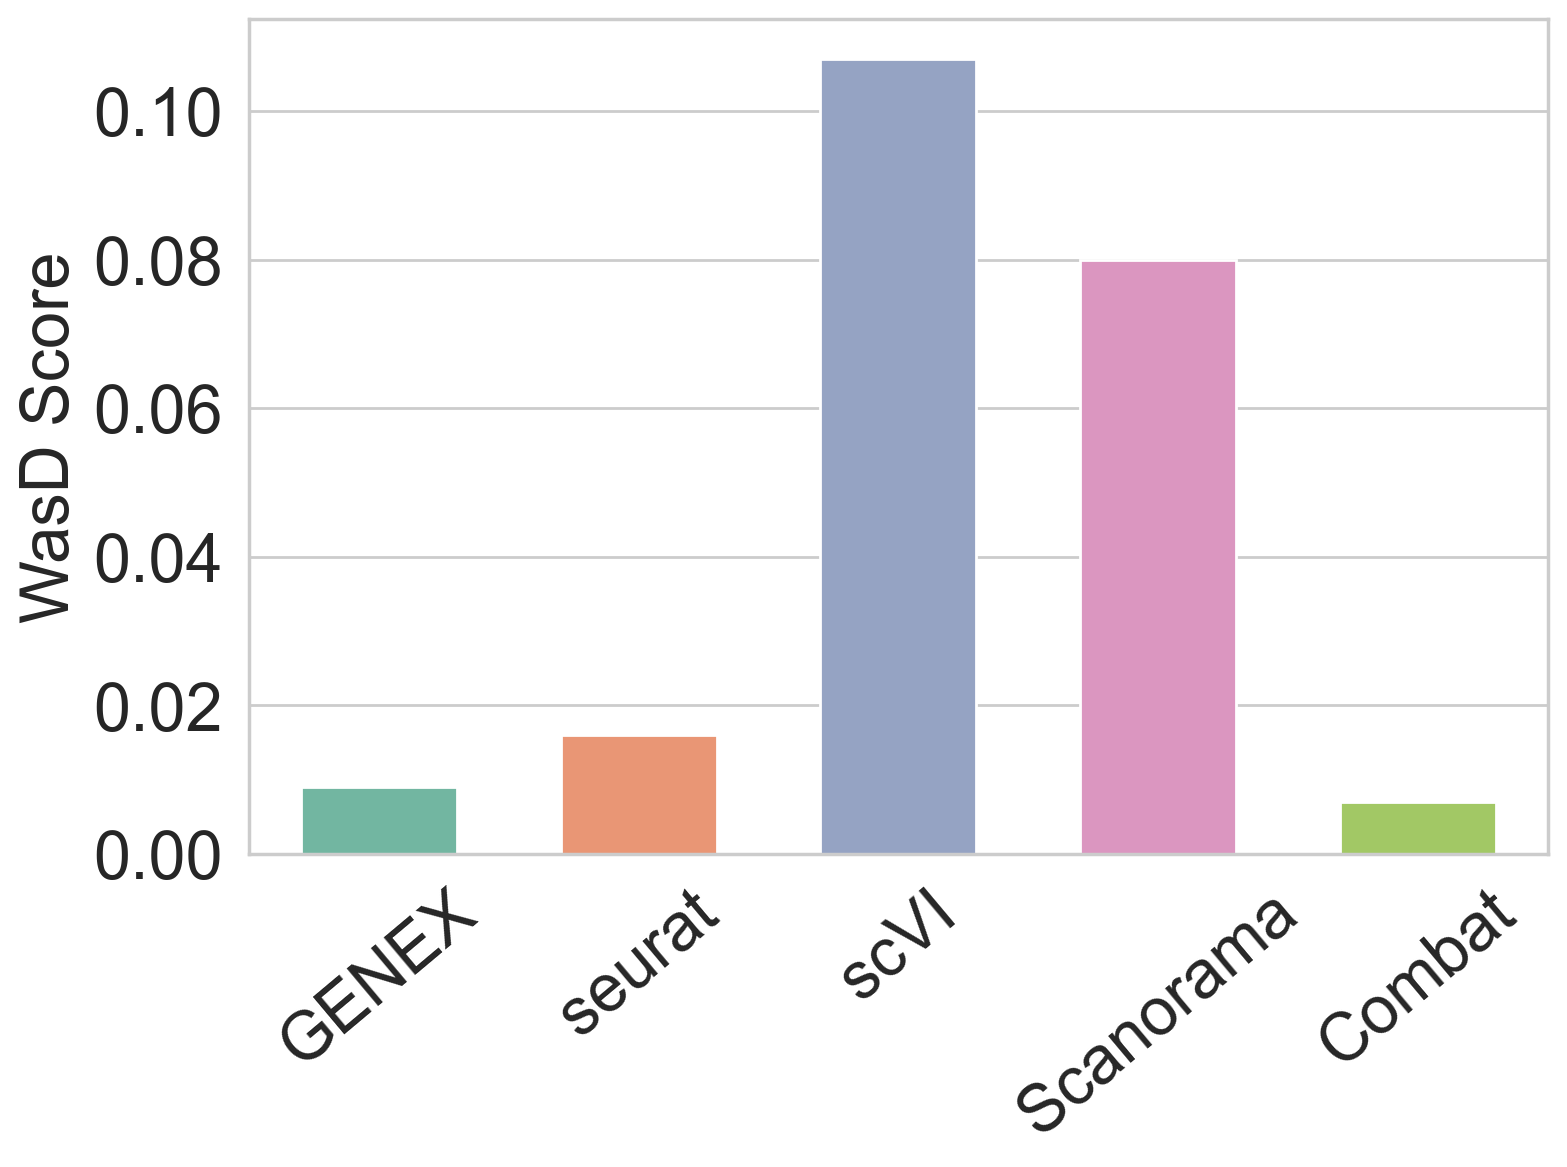

In [121]:
# Data dictionary
df_dict = {
    "model": ["GENEX", "seurat", "scVI", "Scanorama", "Combat"],
    "WasD": [0.009, 0.016, 0.107, 0.08, 0.007],
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(df_dict)

# Set the Seaborn style and context
with sns.plotting_context("notebook"):
    sns.set_style("whitegrid")  # You can change the style as needed

    # Create a barplot using Seaborn
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    sns.barplot(x='model', y='WasD', data=df, palette="Set2", width=0.6)

    # Customize the plot
#     plt.title("WasD Scores for Different Models", fontsize=18)
    plt.xlabel("", fontsize=20)
    plt.ylabel("WasD Score", fontsize=24)
    plt.xticks(rotation=40, fontsize = 24)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize = 24)

    # Save the plot as an SVG file
    plt.tight_layout()  # Ensures that labels fit within the figure area
    plt.savefig("figure/score_pbmc.svg", format="svg", bbox_inches="tight")

# Show the plot (if needed)
plt.show()

## Compute for the F1 score with the ground truth

In [567]:
# dataset = "simul1_dropout_47_b1_2000_b2_3000"
# de_genes_df = pd.read_csv('%s/de_genes.txt' % (dataset), sep="\t")

In [620]:
# adata_int = sc.read("genex_simulation_1.h5ad")

# # uncomment this for our model.
# if "X_raw" not in adata_int.layers:
#     adata = sc.read_h5ad('genex_simulation_1.h5ad')
    
#     # subset to only two cell types that has subtle different which are acinar and ductal cell type
# #     adata = adata[adata.obs["celltype"].isin(subset_celltype)].copy()
    
#     adata_int.layers["X_raw"] = adata.layers["X_raw"].copy()
#     adata_int.uns = adata.uns
    
# adata_int.layers["X_raw_scaled"] = sc.pp.scale(adata_int.layers["X_raw"].copy(), copy = True)
# adata_int.layers["X_corrected_scaled"] = sc.pp.scale(adata_int.obsm["X_latent"].copy(), copy = True)

In [621]:
# adata_int.layers["X_corrected"] = adata_int.obsm["X_latent"]

In [622]:
# def compute_logfc(cell_adata, group, group_name, layer):
# #     cell_adata = deg_adata[deg_adata.obs["CellType"] == cell_type_name]
#     group_list = sorted(list(set(cell_adata.obs[group_name])))
    
#     pseudocount = 1

#     group_A = cell_adata[cell_adata.obs[group_name] == group] #BMA
#     group_A_log = np.log2(np.mean(np.expm1(group_A.layers[layer].toarray()), axis = 0) + pseudocount)
    
#     list_logfc = []
    
#     for each in group_list:
#         if each != group:
#             group_B = cell_adata[cell_adata.obs[group_name] == each] #LLN
#             group_B_log = np.log2(np.mean(np.expm1(group_B.layers[layer].toarray()), axis = 0) + pseudocount)

#     #         logfc = pd.DataFrame(np.around(group_A_log - group_B_log, 4), index = cell_adata.var.index, columns = ["logfc"])
#             logfc = np.around(group_A_log - group_B_log, 4)
#             list_logfc.append(logfc)
#     if len(list_logfc) == 1:
#         return pd.DataFrame(list_logfc[0], index = cell_adata.var.index, columns = ["logfc"])
#     else:
#         return pd.DataFrame(np.mean(list_logfc, axis = 1), index = cell_adata.var.index, columns = ["logfc"])

In [623]:
# group_name = "Group_num"
# groups = sorted(list(set(adata_int.obs[group_name])))
# # groups = sorted(list(set(adata_int.obs["Group"])))

# groups

['Group1', 'Group2']

In [624]:
# # adata_int.uns['log1p'] = None
# adata_int.uns['log1p']['base'] = None

In [625]:
# adata_int.layers["X_corrected"][adata_int.layers["X_corrected"] <= 0.25] = 0

In [626]:
# # uncomment for raw data degs
# # adata_int.obsm["X_raw_pca"] = sc.pp.pca(adata_int.layers["X_raw"], copy = True)
# # sc.tl.dendrogram(adata_int, use_rep = "X_raw_pca", groupby = "Group_num", optimal_ordering=False)

# layer_name = "X_corrected"

# sc.tl.dendrogram(adata_int, use_rep = "X_pca", groupby = group_name, optimal_ordering=False)
# sc.tl.rank_genes_groups(adata_int, group_name, method='t-test', use_raw = False, corr_method='bonferroni', layer = layer_name, pts = True)
# adata_int.X = adata_int.layers[layer_name]
# sc.tl.filter_rank_genes_groups(adata_int, min_in_group_fraction=0.25, key = "rank_genes_groups",
#                                max_out_group_fraction = 1.01,
#                                min_fold_change=0.0)


# raw_deg = sc.get.rank_genes_groups_df(adata_int, group = groups[0], pval_cutoff=0.05, key='rank_genes_groups_filtered')["names"]

# deg_fc = compute_logfc(adata_int, groups[0], group_name, layer_name)
    
# ## get only the significance genes
# boolean_pvalue = []

# for gene in deg_fc.index:
#     if gene in list(raw_deg):
#         boolean_pvalue.append(True)
#     else:
#         boolean_pvalue.append(False)

# deg_fc["pvalue"] = boolean_pvalue

# # filtering for the log fold change and the pvalue
# filtered = (deg_fc["pvalue"] == True) & ((deg_fc["logfc"] > 0.0) | (deg_fc["logfc"] < -0.0))

# # for scVI and Scanorama as they have normalised their data, we only take the p-value
# # filtered = (deg_fc["pvalue"] == True)

# deg_fc_filtered = deg_fc[filtered]

# #     deg_set = deg_set[~pd.isnull(deg_set)][:10]

# #     deg_set = np.array(deg_set)

# # deg_gene = deg_fc_filtered.sort_values(by="logfc", ascending = False).index.values

# raw_deg = deg_fc_filtered.index.values

# print(len(raw_deg))

183

In [627]:
# raw_deg

array(['Gene36', 'Gene60', 'Gene131', 'Gene181', 'Gene226', 'Gene237',
       'Gene265', 'Gene268', 'Gene296', 'Gene309', 'Gene337', 'Gene340',
       'Gene489', 'Gene543', 'Gene566', 'Gene616', 'Gene620', 'Gene640',
       'Gene669', 'Gene677', 'Gene693', 'Gene775', 'Gene906', 'Gene924',
       'Gene933', 'Gene944', 'Gene971', 'Gene975', 'Gene1023', 'Gene1040',
       'Gene1120', 'Gene1127', 'Gene1154', 'Gene1164', 'Gene1184',
       'Gene1198', 'Gene1200', 'Gene1267', 'Gene1301', 'Gene1324',
       'Gene1357', 'Gene1375', 'Gene1406', 'Gene1440', 'Gene1441',
       'Gene1493', 'Gene1585', 'Gene1647', 'Gene1676', 'Gene1686',
       'Gene1717', 'Gene1751', 'Gene1777', 'Gene1788', 'Gene1803',
       'Gene1891', 'Gene1900', 'Gene1907', 'Gene2001', 'Gene2025',
       'Gene2052', 'Gene2053', 'Gene2058', 'Gene2078', 'Gene2085',
       'Gene2113', 'Gene2127', 'Gene2139', 'Gene2143', 'Gene2160',
       'Gene2191', 'Gene2228', 'Gene2243', 'Gene2245', 'Gene2262',
       'Gene2280', 'Gene2362', '

In [628]:
# deg_fc

,logfc,pvalue
Gene2,-0.0041,False
Gene3,0.1448,False
Gene4,0.1278,False
Gene5,-0.0027,False
Gene6,-0.0050,False
...,...,...
Gene4996,-1.1197,False
Gene4997,-0.0013,False
Gene4998,-0.0023,False
Gene4999,0.0237,False


In [629]:
# from sklearn.metrics import f1_score

# # let compute for the F1 score
# # first get all the genes list as we need to convert into 0 and 1
# all_genes = adata_int.var.index.values

# # getting the true labels based on the ground truth
# true_labels = [1 if each in de_genes_df.values.reshape(-1) else 0 for each in all_genes]
# pred_labels = [1 if each in raw_deg else 0 for each in all_genes]

# f1_score(true_labels, pred_labels)

0.34674329501915707

In [314]:
# # Data dictionary
# df_dict = {
#     "model": ["Unintegrated", "GENEX", "GENEX (xAI)", "seurat", "scVI", "Scanorama", "Combat"],
#     "F1 score": [0.043, 0.364, 0.389, 0.277, 0.273, 0.048, 0.346]
# }

# # Create a DataFrame from the dictionary
# df = pd.DataFrame(df_dict)

# # Set the Seaborn style and context
# with sns.plotting_context("notebook"):
#     sns.set_style("whitegrid")  # You can change the style as needed

#     # Create a barplot using Seaborn
#     plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
#     sns.barplot(x='model', y='F1 score', data=df_dict, palette="Set2", width=0.6)

#     # Customize the plot
# #     plt.title("WasD Scores for Different Models", fontsize=18)
#     plt.xlabel("", fontsize=20)
#     plt.ylabel("F1 score", fontsize=24)
#     plt.xticks(rotation=40, fontsize = 24)  # Rotate x-axis labels for better readability
#     plt.yticks(fontsize = 24)

#     # Save the plot as an SVG file
#     plt.tight_layout()  # Ensures that labels fit within the figure area
#     plt.savefig("figure/score_pbmc.svg", format="svg", bbox_inches="tight")

# # Show the plot (if needed)
# plt.show()

In [636]:
dataset = "simul1_dropout_47_b1_2000_b2_3000"

# true_down_genes_df = pd.read_csv('%s/true_down_genes.txt' % (dataset), sep="\t")
# true_up_genes_df = pd.read_csv('%s/true_up_genes.txt' % (dataset), sep="\t")
true_counts = pd.read_csv('%s/truecounts.txt' % (dataset), sep="\t").values.transpose()

true_counts = true_counts.astype('float')

true_counts = sc.pp.normalize_per_cell(true_counts, counts_per_cell_after=1e4, copy = True)
true_counts = np.log1p(true_counts)

from sklearn.metrics import mean_squared_error

In [637]:
true_counts

array([[0.        , 0.        , 0.90438466, ..., 0.42833168, 0.51184637,
        0.78984903],
       [0.        , 0.        , 1.2784071 , ..., 0.18836428, 0.48354876,
        0.97764384],
       [0.        , 0.        , 1.49262054, ..., 0.45412175, 0.45412175,
        0.85065338],
       ...,
       [0.        , 0.        , 0.65386149, ..., 0.55294305, 0.16939706,
        0.        ],
       [0.        , 0.23278449, 0.77909208, ..., 1.24991315, 0.        ,
        0.        ],
       [0.        , 0.14579907, 1.11203119, ..., 0.74133996, 0.        ,
        0.        ]])

In [638]:
subset_index = [int(each[4:]) - 1 for each in adata_int.obs.index.values]
subset_genes = [int(each[4:]) - 1 for each in adata_int.var.index.values]
true_counts = true_counts[subset_index]
true_counts = true_counts[:, subset_genes]
true_counts.shape

(8523, 4690)

In [655]:
adata_int = sc.read("combat_simulation_1.h5ad")

# uncomment this for our model.
if "X_raw" not in adata_int.layers:
    adata = sc.read_h5ad('genex_simulation_2.h5ad')
    
    # subset to only two cell types that has subtle different which are acinar and ductal cell type
#     adata = adata[adata.obs["celltype"].isin(subset_celltype)].copy()
    
    adata_int.layers["X_raw"] = adata.layers["X_raw"].copy()
    adata_int.uns = adata.uns
    
pred_counts = adata_int.obsm["X_latent"]
    
adata_int

AnnData object with n_obs × n_vars = 8523 × 4690
    obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm', 'highly_variable_intersection'
    uns: 'Batch_num_colors', 'Group_num_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    layers: 'X_raw', 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'

In [656]:
pred_counts

array([[ 2.08788878e-03,  1.05862288e-02,  4.34566957e-01, ...,
        -5.25963104e-03, -7.44453044e-03, -1.06565834e-02],
       [ 2.08788878e-03,  1.05862288e-02,  3.58728053e+00, ...,
        -5.25963104e-03, -7.44453044e-03, -1.06565834e-02],
       [ 2.08788878e-03,  1.05862288e-02,  4.34566957e-01, ...,
        -5.25963104e-03, -7.44453044e-03,  1.04683598e+00],
       ...,
       [ 1.53772513e-03,  3.49730094e-02,  3.52067266e+00, ...,
        -2.06772842e-02,  6.27629465e-03,  3.55615661e-02],
       [ 1.53772513e-03,  3.49730094e-02,  3.53385023e+00, ...,
        -2.06772842e-02,  6.27629465e-03,  3.55615661e-02],
       [ 1.53772513e-03,  3.49730094e-02,  3.21097794e-03, ...,
        -2.06772842e-02,  6.27629465e-03,  3.55615661e-02]])

In [657]:
np.amax(adata_int.layers["X_raw"])

6.726569

In [658]:
mean_squared_error(true_counts, pred_counts)

0.6410622367379658

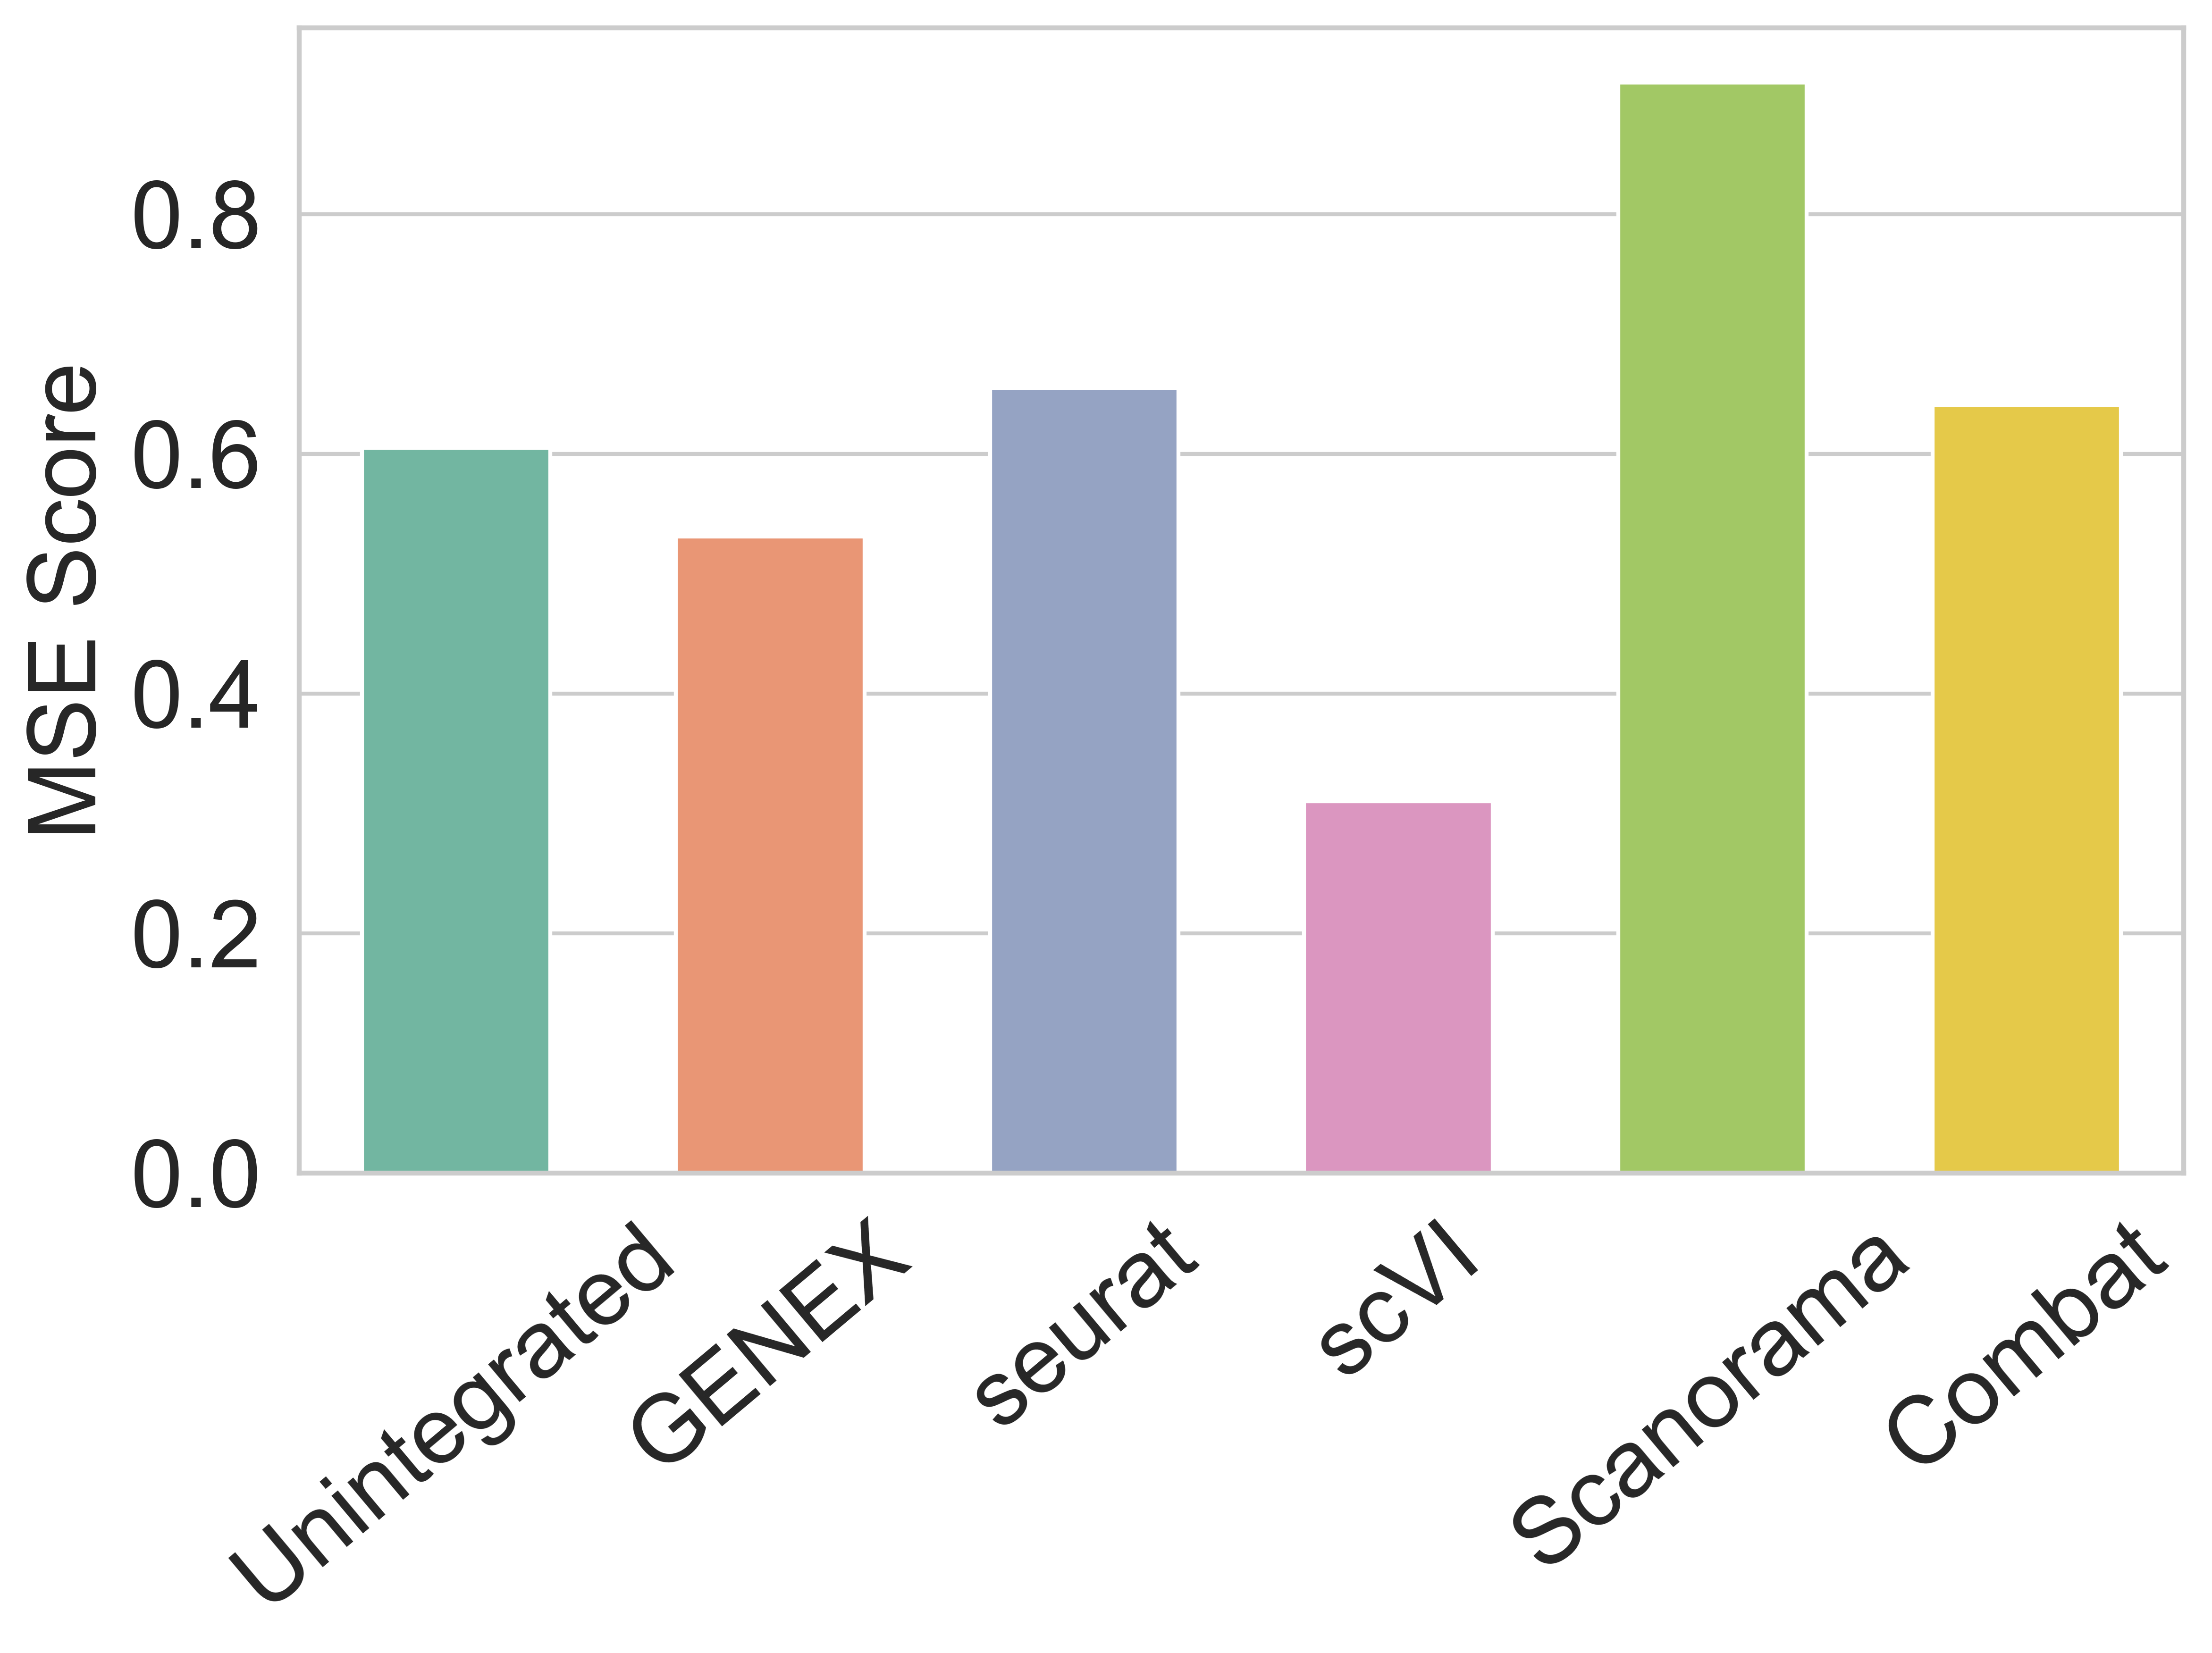

In [535]:
import seaborn as sns

# Data dictionary
df_dict = {
    "model": ["Unintegrated", "GENEX", "seurat", "scVI", "Scanorama", "Combat"],
    "MSE score": [0.605, 0.547, 0.655, 0.310, 0.910, 0.641]
}

# Set the Seaborn style and context
with sns.plotting_context("notebook"):
    sns.set_style("whitegrid")  # You can change the style as needed

    # Create a barplot using Seaborn
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    sns.barplot(x='model', y='MSE score', data=df_dict, palette="Set2", width=0.6)

    # Customize the plot
#     plt.title("WasD Scores for Different Models", fontsize=18)
    plt.xlabel("", fontsize=20)
    plt.ylabel("MSE Score", fontsize=24)
    plt.xticks(rotation=40, fontsize = 24)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize = 24)

    # Save the plot as an SVG file
    plt.tight_layout()  # Ensures that labels fit within the figure area
    plt.savefig("figure/score_pbmc.svg", format="svg", bbox_inches="tight")

# Show the plot (if needed)
plt.show()

In [18]:
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

In [19]:
model_list = ["seurat", "scVI", "scVI", "scanorama", "scanorama", "combat"]
model_name = ["Seurat", "scVI", "scVI (Emb)", "Scanorama", "Scanorama (Emb)", "Combat"]

In [22]:
adata_int = sc.read("genex_pbmc_2.h5ad")

# uncomment this for our model.
if "X_raw" not in adata_int.layers:
    adata = sc.read_h5ad('genex_pbmc.h5ad')
    
    # subset to only two cell types that has subtle different which are acinar and ductal cell type
#     adata = adata[adata.obs["celltype"].isin(subset_celltype)].copy()
    
    adata_int.layers["X_raw"] = adata.layers["X_raw"].copy()
    adata_int.uns = adata.uns
    
adata_int.obsm["GENEX"] = adata_int.obsm["X_pca"]
adata_int.obsm["Unintegrated"] = sc.pp.pca(adata_int.layers["X_raw"], copy = True)

# the rest of the PCA from corrected genes
    
adata_int

AnnData object with n_obs × n_vars = 15476 × 10000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', 'batch_num'
    var: 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'CellType_colors', 'batch_colors', 'hvg', 'log1p', 'louvain', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap', 'GENEX', 'Unintegrated'
    layers: 'X_raw', 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'

In [23]:
# adata_temp = sc.read("%s_simulation_1.h5ad" % (model_list[2]))
# adata_temp.obs

In [24]:
# get all the X_PCA for all the integrated method
for i in range(len(model_list)):
    adata_temp = sc.read("%s_pbmc.h5ad" % (model_list[i]))
    print(adata_temp)
    
    print(i)
    if i == 4:
        adata_int.obsm[model_name[i]] = adata_temp.obsm["X_scanorama"].copy()
    elif i == 2:
        adata_int.obsm[model_name[i]] = adata_temp.obsm["X_scVI"].copy()
    else:
        adata_int.obsm[model_name[i]] = adata_temp.obsm["X_pca"].copy()

AnnData object with n_obs × n_vars = 15476 × 10000
    obs: 'CellType', 'Method', 'batch', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'louvain'
    var: 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'CellType_colors', 'Method_colors', 'batch_colors', 'louvain', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'
0
AnnData object with n_obs × n_vars = 15476 × 10000
    obs: 'Sample', 'n_counts', 'n_genes', 'batch', 'louvain', 'anno', 'Method', 'CellType', '_scvi_batch', '_scvi_labels'
    var: 'gene_name', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'CellType_colors', 'Method_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'hvg', 'log1p', 'louvain', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_scVI', 'X_umap'
    layers: 'X_raw', 'counts

In [25]:
# print(np.around(adata_int.obsm["X_latent"], 5))

In [26]:
import faiss

from scib_metrics.nearest_neighbors import NeighborsOutput


def faiss_hnsw_nn(X: np.ndarray, k: int):
    """Gpu HNSW nearest neighbor search using faiss.

    See https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
    for index param details.
    """
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    M = 32
    index = faiss.IndexHNSWFlat(X.shape[1], M, faiss.METRIC_L2)
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsOutput(indices=indices, distances=np.sqrt(distances))


def faiss_brute_force_nn(X: np.ndarray, k: int):
    """Gpu brute force nearest neighbor search using faiss."""
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    index = faiss.IndexFlatL2(X.shape[1])
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsOutput(indices=indices, distances=np.sqrt(distances))

In [27]:
adata_int.obsm["X_latent"]

array([[0.        , 0.        , 0.        , ..., 0.08804815, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.06247318, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.09831575, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [28]:
adata_int.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
setup_seed(9)

In [30]:
biocons = BioConservation(nmi_ari_cluster_labels_kmeans=False, silhouette_label =  True, nmi_ari_cluster_labels_leiden = True, )
batchcons = BatchCorrection(kbet_per_label = True)


bm = Benchmarker(
    adata_int,
    batch_key="Method",
    label_key="CellType",
    embedding_obsm_keys=["Unintegrated", "GENEX", "Seurat", "scVI", "scVI (Emb)", "Scanorama", "Scanorama (Emb)", "Combat"],
    bio_conservation_metrics = biocons,
    batch_correction_metrics = batchcons,
    n_jobs=-1,
)

# using GPU to compute for neighbor for faster computation
bm.prepare(neighbor_computer=faiss_brute_force_nn)
bm.benchmark()

Metrics:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 8/10 [00:42<00:17,  8.86s/it, Batch correction: pcr_comparison]/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(

Metrics:   0%|                                                                                                                                                                                                                        | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                             
Metr

Metrics:   0%|                                                                                                                                                                                                                        | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                             
Metrics:   0%|                                                                                                                                                                                                                        | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                              

Metrics:   0%|                                                                                                                                                                                                                        | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                             
Embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:05<00:00, 45.63s/it]

                                                                                                                                                                                                                                             

In [31]:
# dasd

In [32]:
# # Adding F1 score to the table
# bm._results.loc["F1"] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] + ["Bio conservation"]
# bm._results.loc["MSE"] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] + ["Bio conservation"]
# bm._results.loc["Wasserstein\nDistance"] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] + ["Bio conservation"]

# # Grouping up the bio and batch correction labels
# bm._results.sort_values("Metric Type", inplace = True)

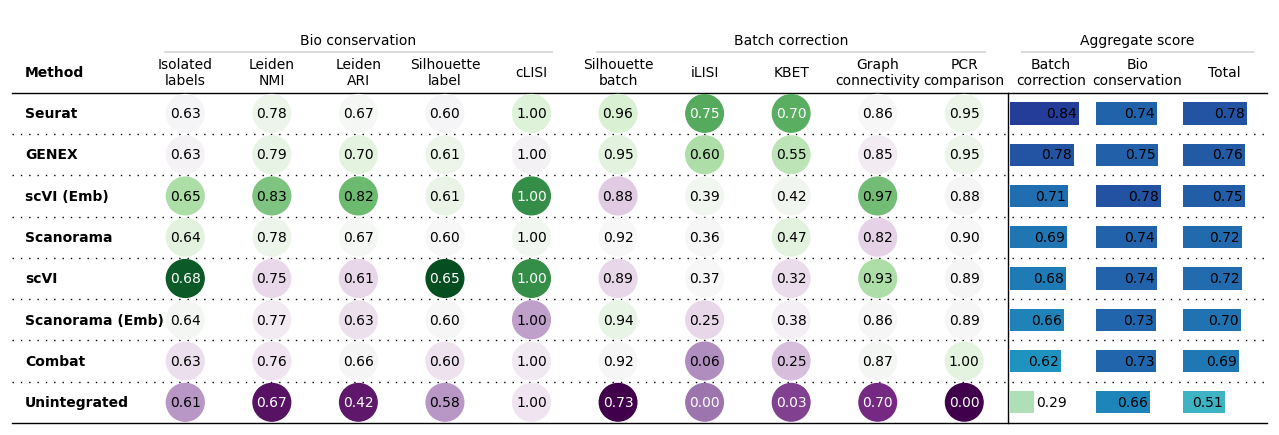

In [33]:
bm.plot_results_table(min_max_scale=False, save_dir = "scIB_pbmc")

In [34]:
# from rich import print

# df = bm.get_results(min_max_scale=False)
# print(df)

In [35]:
# df.transpose()

Monocyte_CD14
974


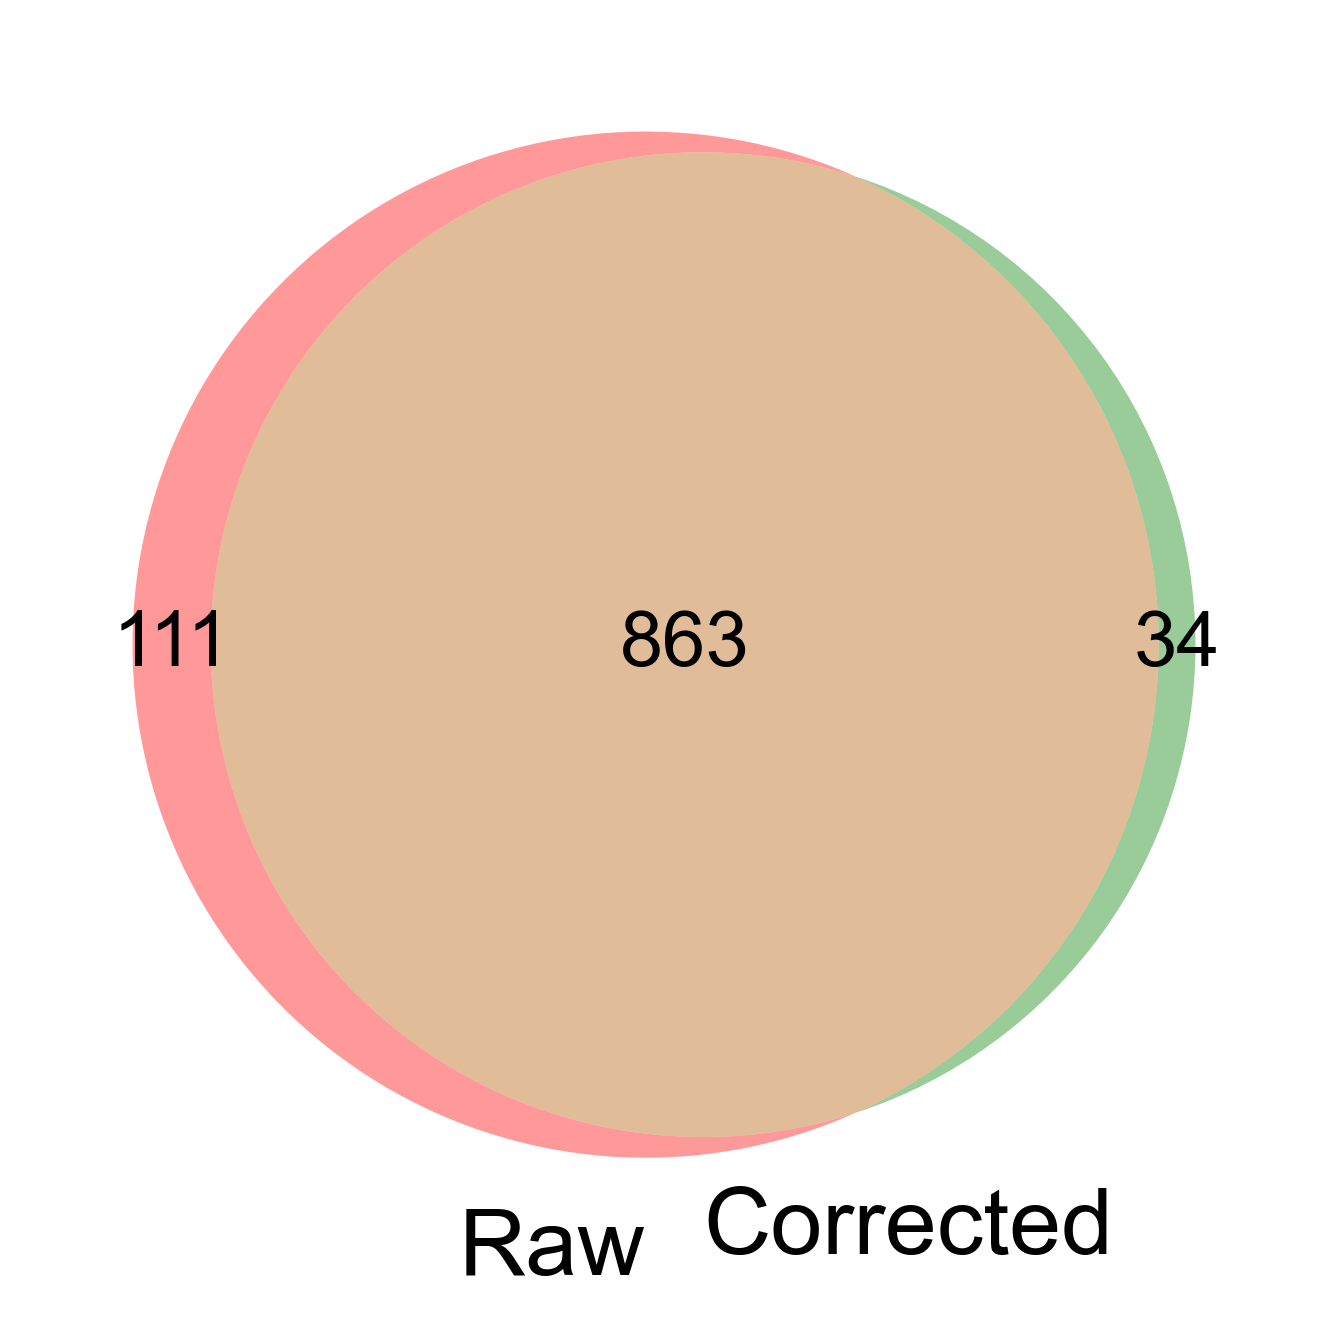

In [21]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

for each in sorted(common_celltype):
    
    if each == "Monocyte_CD14":
        print(each)

        sc.tl.rank_genes_groups(adata_int, 'CellType', method='t-test', use_raw = False, corr_method='benjamini-hochberg', layer = "X_raw")

        raw_deg = sc.get.rank_genes_groups_df(adata_int, group = each, log2fc_max = 0.0, pval_cutoff=0.05)["names"].values

        print(len(raw_deg))

        sc.tl.rank_genes_groups(adata_int, 'CellType', method='t-test', use_raw = False, corr_method='benjamini-hochberg', layer = "X_corrected")

        corrected_deg = sc.get.rank_genes_groups_df(adata_int, group = each, log2fc_max = 0.0, pval_cutoff=0.05)["names"].values

        venn2([set(raw_deg), set(corrected_deg)], set_labels = ('Raw', 'Corrected'))
        # print("for delta cell type")

        plt.show()

In [30]:
# raw_only = []

# for gene in raw_deg:
#     if gene not in corrected_deg:
#         raw_only.append(gene)
        
# raw_only